In [3]:
!pip install -U albumentations>=3.0.0
!git clone https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models

Cloning into 'TensorFlow-Advanced-Segmentation-Models'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 276 (delta 126), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (276/276), 101.14 KiB | 4.82 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [4]:
%cd TensorFlow-Advanced-Segmentation-Models
from tf_segmentation_models import losses, metrics
from tf_segmentation_models.backbones import tf_backbones
from tf_segmentation_models.models import fpnet
from tf_segmentation_models.base import functional, objects
%cd ..

/content/TensorFlow-Advanced-Segmentation-Models
/content


In [5]:
import os
import cv2
import numpy as np
from time import time
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

In [6]:
# Data Handling

DATA_DIR = "drive/My Drive/dataset1"

x_train_dir = os.path.join(DATA_DIR, 'parent_train_img/train_img')
y_train_dir = os.path.join(DATA_DIR, 'parent_train_annot/train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'parent_val_img/val_img')
y_valid_dir = os.path.join(DATA_DIR, 'parent_val_annot/val_annot')

x_test_dir = os.path.join(DATA_DIR, 'parent_test_img/test_img')
y_test_dir = os.path.join(DATA_DIR, 'parent_test_annot/test_annot')


# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(height, width):
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.6, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0),
        A.RandomCrop(height=height, width=width, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(height, width):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(height, width),
        A.Resize(height, width, always_apply=True)
    ]
    return A.Compose(test_transform)

def data_get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [7]:
TOTAL_CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
N_TOTAL_CLASSES = 12
# CLASSES_DICT = {"sky": 0, "building": 1, "pole": 2, "road": 3, "pavement": 4,
#                 "tree": 5, "signsymbol": 6, "fence": 7, "car": 8,
#                 "pedestrian": 9, "bicyclist": 10, "unlabelled": 11}
# Dervied from Matlab: https://it.mathworks.com/help/vision/examples/semantic-segmentation-using-deep-learning.html
CLASSES_PIXEL_COUNT_DICT = {"sky": 76801000, "building": 117370000,
                            "pole": 4799000, "road": 140540000,
                            "pavement": 33614000, "tree": 54259000,
                            "signsymbol": 5224000, "fence": 69211000,
                            "car": 2437000, "pedestrian": 3403000,
                            "bicyclist": 2591000, "unlabelled": 0}

MODEL_CLASSES = ["sky", "building"]
BATCH_SIZE = 4
N_CLASSES = 3
HEIGHT = 160
WIDTH = 160
BACKBONE_NAME = "efficientnetb3"
WEIGHTS = "imagenet"

In [8]:
################################################################################
# Class Weights
################################################################################
def get_dataset_counts(d):
    pixel_count = np.array([i for i in d.values()])

    sum_pixel_count = 0
    for i in pixel_count:
        sum_pixel_count += i

    return pixel_count, sum_pixel_count

def get_dataset_statistics(pixel_count, sum_pixel_count):
    
    pixel_frequency = np.round(pixel_count / sum_pixel_count, 4)

    mean_pixel_frequency = np.round(np.mean(pixel_frequency), 4)

    return pixel_frequency, mean_pixel_frequency

def get_balancing_class_weights(classes, d):
    pixel_count, sum_pixel_count = get_dataset_counts(d)

    background_pixel_count = 0
    mod_pixel_count = []
    for c in TOTAL_CLASSES:
        if c not in classes:
            background_pixel_count += d[c]
        else:
            mod_pixel_count.append(d[c])
    mod_pixel_count.append(background_pixel_count)
    
    pixel_frequency, mean_pixel_frequency = get_dataset_statistics(mod_pixel_count, sum_pixel_count)

    class_weights = np.round(mean_pixel_frequency / pixel_frequency, 2)
    return class_weights    

class_weights = get_balancing_class_weights(MODEL_CLASSES, CLASSES_PIXEL_COUNT_DICT)
print(class_weights)

[2.21 1.45 0.54]


In [9]:
################################################################################
# Data Generator
################################################################################
def create_image_label_path_generator(images_dir, masks_dir):
    ids = sorted(os.listdir(images_dir))
    images_fps = [os.path.join(images_dir, image_id) for image_id in ids]
    mask_ids = sorted(os.listdir(masks_dir))
    masks_fps = [os.path.join(masks_dir, image_id) for image_id in mask_ids]

    while True:
        for i in range(len(images_fps)):
            yield [images_fps[i], masks_fps[i]]


def process_image_label(images_paths, masks_paths, classes, augmentation=None, preprocessing=None):
    class_values = [TOTAL_CLASSES.index(cls.lower()) for cls in classes]
    
    # read data
    image = cv2.imread(images_paths)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks_paths, 0)

    # extract certain classes from mask (e.g. cars)
    masks = [(mask == v) for v in class_values]
    mask = np.stack(masks, axis=-1).astype('float')
    
    # add background if mask is not binary
    if mask.shape[-1] != 1:
        background = 1 - mask.sum(axis=-1, keepdims=True)
        mask = np.concatenate((mask, background), axis=-1)
    
    # apply augmentations
    if augmentation:
        sample = augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if preprocessing:
        sample = preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    # mask = np.squeeze(np.argmax(mask, axis=-1))
    # mask = np.argmax(mask, axis=-1)
    # mask = mask[..., np.newaxis]
        
    return image, mask

def DataGenerator(train_dir, label_dir, batch_size, height, width, classes, augmentation):
    image_label_path_generator = create_image_label_path_generator(
        train_dir, label_dir
    )
    while True:
        images = np.zeros(shape=[batch_size, height, width, 3])
        labels = np.zeros(shape=[batch_size, height, width, len(classes) + 1], dtype=np.float32)
        for i in range(batch_size):
            image_path, label_path = next(image_label_path_generator)
            image, label = process_image_label(image_path, label_path, classes=classes, augmentation=augmentation)
            images[i], labels[i] = image, label

        yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)

In [10]:
backbone, layers, layer_names = tf_backbones.create_backbone(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

model = fpnet.FPNet(n_classes=N_CLASSES, backbone=backbone)

43941888/43941136 [==============================] - 0s 0us/step


In [11]:
opt = tf.keras.optimizers.SGD(learning_rate=0.25, momentum=0.9)
metrics = [metrics.IOUScore(class_weights=class_weights, threshold=0.5)]
categorical_focal_dice_loss = losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + losses.DiceLoss()

model.compile(
    # optimizer=tf.keras.optimizers.Adam(lr=1e-4),
    optimizer=opt,
    # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
            #  tf.keras.callbacks.ModelCheckpoint("DeepLabV3plus.ckpt", verbose=1, save_weights_only=True, save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=1, mode="min"),
             tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=13, mode="min", verbose=1, restore_best_weights=True)
]

In [12]:
TrainSet = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH)
    )

TrainSetwoAug = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH)
)

ValidationSet = DataGenerator(
    x_valid_dir,
    y_valid_dir,
    1,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
)

TestSet = DataGenerator(
    x_test_dir,
    y_test_dir,
    1,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
)

for i in TrainSet:
    sample_image, sample_mask = i[0][0], i[1][0]
    print(len(i))
    print(i[0].shape)
    print(i[1].shape)
    break

print(len(os.listdir(x_train_dir)))
print(len(os.listdir(x_valid_dir)))
print(len(os.listdir(x_test_dir)))

2
(4, 160, 160, 3)
(4, 160, 160, 3)
307
60
101



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

SparseCategoricalCrossentroy: 1.8368808
Iou-Score: 0.109362684
categorical Focal Dice Loss: 0.9149754


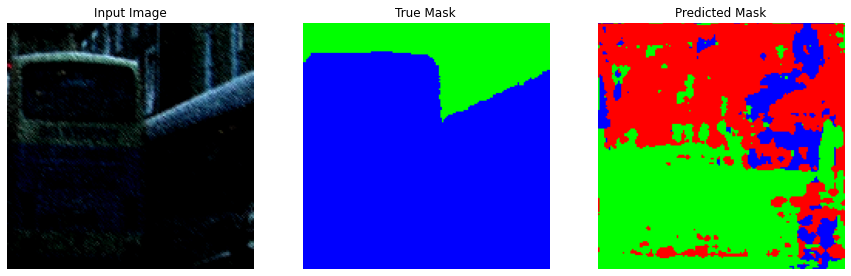

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    
    output_model = model(sample_image[tf.newaxis, ...])
    # print(output_model.numpy())
    
    output_mask = create_mask(output_model)
    # print(sample_mask.shape)

    scce = tf.keras.losses.CategoricalCrossentropy()
    print("SparseCategoricalCrossentroy: " + str(scce(sample_mask, output_model[0]).numpy()))
    # print(iou_score(sample_mask, output_model[0]))
    print("Iou-Score: " + str(losses.iou_score(sample_mask, output_model[0]).numpy()))
    # print("Dice Loss: " + str(dice_loss(sample_mask, output_model[0]).numpy()))
    # print("Categorical Focal Loss: " + str(categorical_focal_loss(sample_mask, output_model[0]).numpy()))
    print("categorical Focal Dice Loss: " + str(categorical_focal_dice_loss(sample_mask, output_model[0]).numpy()))
    
    display([sample_image, sample_mask, K.one_hot(K.squeeze(output_mask, axis=-1), 3)])
    
show_predictions()

In [14]:
history = model.fit(
    TrainSet,
    steps_per_epoch=np.floor(len(os.listdir(x_train_dir)) / BATCH_SIZE),
    epochs=15,
    callbacks=callbacks,
    validation_data=ValidationSet,
    validation_steps=len(os.listdir(x_valid_dir)),
    )

Epoch 1/15
76/76 [==============================] - 406s 5s/step - loss: 0.7015 - iou_score: 0.5284 - val_loss: 0.3632 - val_iou_score: 0.9521
Epoch 2/15
76/76 [==============================] - 106s 1s/step - loss: 0.6262 - iou_score: 0.5651 - val_loss: 0.3923 - val_iou_score: 0.7630
Epoch 3/15
76/76 [==============================] - 105s 1s/step - loss: 0.5798 - iou_score: 0.6120 - val_loss: 0.2645 - val_iou_score: 0.9312
Epoch 4/15
76/76 [==============================] - 106s 1s/step - loss: 0.5601 - iou_score: 0.6551 - val_loss: 0.1985 - val_iou_score: 1.0772
Epoch 5/15
76/76 [==============================] - 107s 1s/step - loss: 0.5330 - iou_score: 0.6858 - val_loss: 0.2160 - val_iou_score: 1.0619
Epoch 6/15
76/76 [==============================] - 106s 1s/step - loss: 0.5516 - iou_score: 0.6736 - val_loss: 0.1813 - val_iou_score: 1.0903
Epoch 7/15
76/76 [==============================] - 106s 1s/step - loss: 0.5508 - iou_score: 0.6681 - val_loss: 0.2045 - val_iou_score: 1.0630

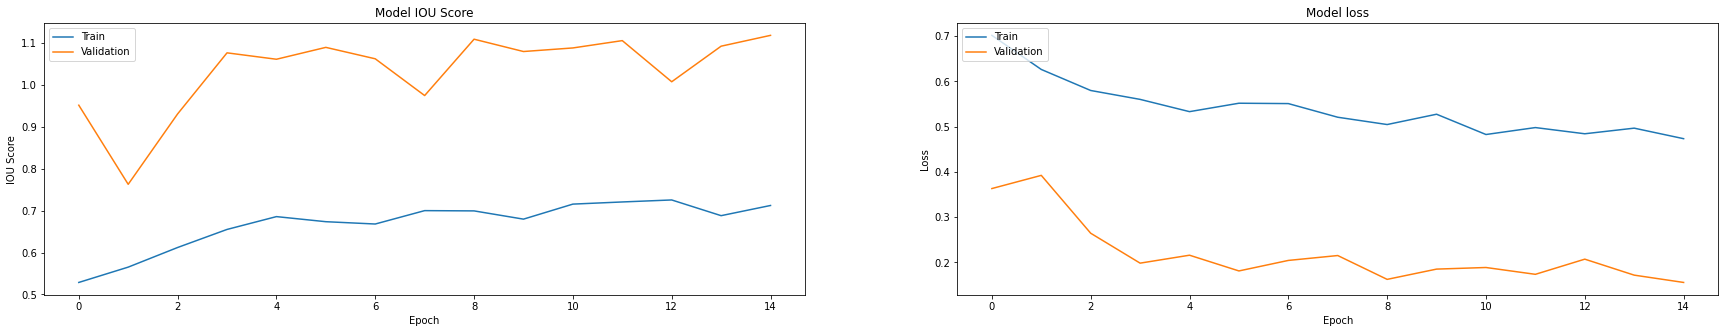

In [15]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
scores = model.evaluate(TestSet, steps=101)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    if metric != "accuracy":
        metric = metric.__name__
    print("mean {}: {:.5}".format(metric, value))

101/101 [==============================] - 113s 1s/step - loss: 0.1411 - iou_score: 1.1278
Loss: 0.14113
mean iou_score: 1.1278


[46 83 98 88 30]
30


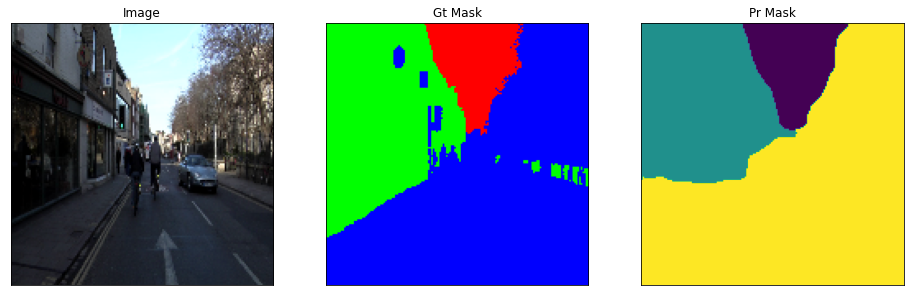

46


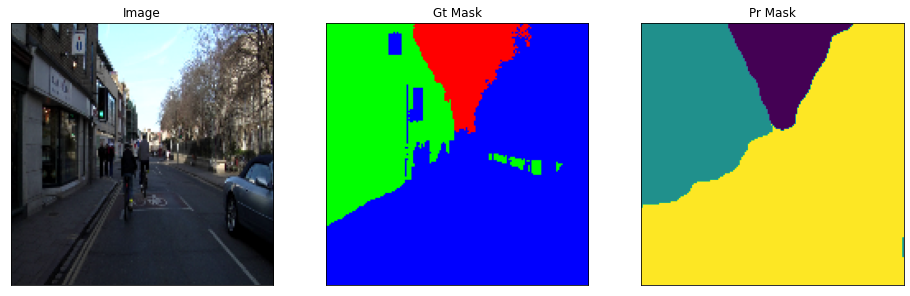

83


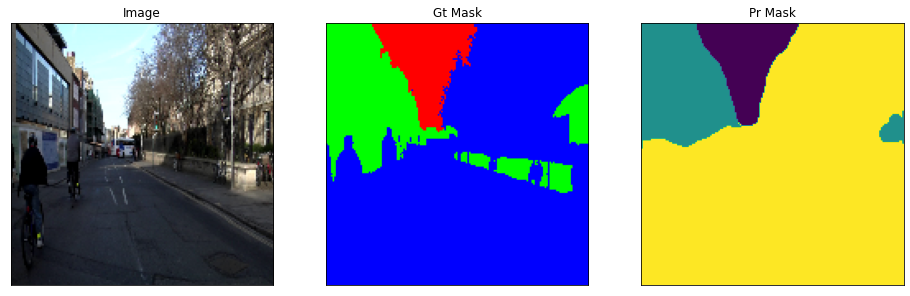

88


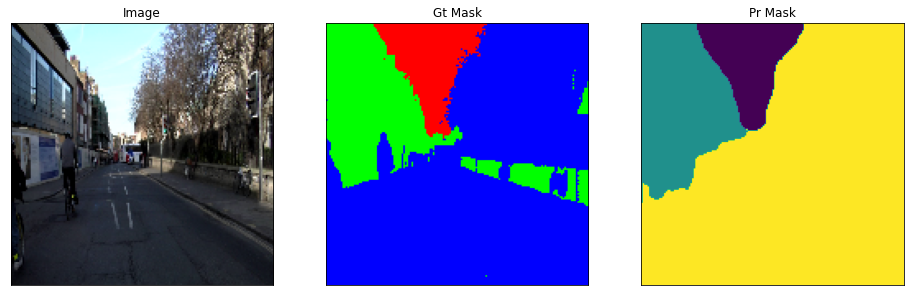

98


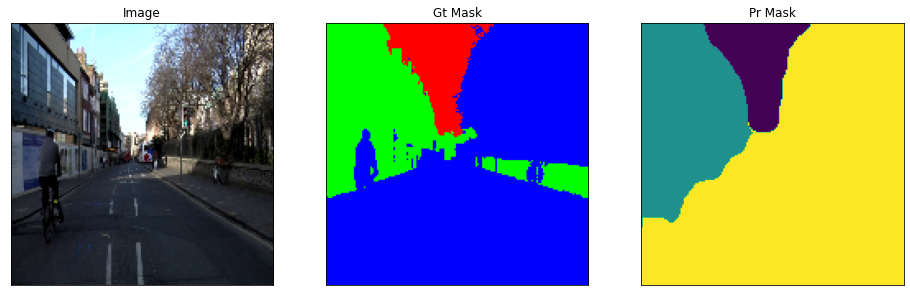

In [17]:
n = 5
ids = np.random.choice(np.arange(101), size=n,replace=False)
print(ids)

counter = 0
second_counter = 0
for i in TestSet:
    if counter in ids:
        image, gt_mask = i
        # image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image)
        pr_mask = np.argmax(pr_mask, axis=-1)

        print(counter)
        
        visualize(
            image=denormalize(image.numpy().squeeze()),
            gt_mask=gt_mask.numpy().squeeze(),
            pr_mask=pr_mask.squeeze(),
        )
        second_counter += 1
    counter += 1
    if second_counter == n:
        break